In [1]:
import numpy as np
from scipy.stats import pearsonr
import datetime
import pandas as pd
from scipy.stats import linregress
from netCDF4 import Dataset
from scipy.interpolate import griddata
import os
import pickle
import itertools
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import gridspec
import cartopy.crs as ccrs
import seaborn as sns
import cartopy
import numpy.ma as ma
import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
# load snow depth and AK freeboard data from 01/10/2018 - 30/04/2020
snow = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/data/SMLG_snod_EASE.nc')['Snow Depth'])[1369:]
all_fbs = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/freeboard_daily_interpolated/AK_CPOM_full.nc')['Radar Freeboard'])[1369:]

### calculate smoothed regional anomalies correlation between AK and SM-LG per grid cell

In [3]:
# do smooth anoms for each grid cell

T1 = 15 ## for 31-day running mean put T=15
T2 = 4 ## for 9-day running mean of anomalies put T=4

freeb_anoms_big = np.full(snow.shape,np.nan)
snows_anoms_big = np.full(snow.shape,np.nan)

for day in tqdm.trange(snow.shape[0]):
    
    # each day, make the 31 day running mean (15 either side) for each grid cell in time dimension
    
    snows_31day = np.nanmean(snow[day-T1:day+T1],axis=0)
    freeb_31day = np.nanmean(all_fbs[day-T1:day+T1],axis=0)
    
    # now make anomalies from 31 day means

    snows_anoms_big[day] = snow[day] - snows_31day 
    freeb_anoms_big[day] = all_fbs[day] - freeb_31day

fb_running_mean_anoms = np.full(snow.shape,np.nan)
sd_running_mean_anoms = np.full(snow.shape,np.nan)

# 9 day mean of anoms for each grid cell in time dimension
for day in tqdm.trange(snow.shape[0]):
    
        fb_running_mean_anoms[day] = np.nanmean(freeb_anoms_big[day-T2:day+T2],axis=0) 
        sd_running_mean_anoms[day] = np.nanmean(snows_anoms_big[day-T2:day+T2],axis=0)

100%|██████████████████████████████████████| 2649/2649 [00:18<00:00, 144.39it/s]


In [4]:
ps_map = np.full((all_fbs.shape[1],all_fbs.shape[2]), np.nan)
rs_map = np.full((all_fbs.shape[1],all_fbs.shape[2]), np.nan)
ss_map = np.full((all_fbs.shape[1],all_fbs.shape[2]), np.nan)

for i, j in tqdm.tqdm(itertools.product(np.arange(all_fbs.shape[1]),
                              np.arange(all_fbs.shape[2]))):
    
    # calculate p and r for full timeseries per grid cell
    
    mask = ~np.isnan(sd_running_mean_anoms[:,i,j]) & ~np.isnan(fb_running_mean_anoms[:,i,j]) # mask out cells with nan snow or nan freeb
    
    if np.count_nonzero(np.nan_to_num(mask)) > 2: # if more than 2 days in snow and freeb have data then continue
        
            
        rstats = linregress(sd_running_mean_anoms[:,i,j][mask],fb_running_mean_anoms[:,i,j][mask]) # correlate valid snow and freeb for each grid cell 
        r = rstats.rvalue
        p = rstats.pvalue
        s = rstats.slope
        ps_map[i,j] = p
        rs_map[i,j] = r
        ss_map[i,j] = s

129600it [00:07, 18334.29it/s]


In [5]:
### create MYI area line
days = np.arange(0,2649)
dates = [datetime.date(2013,10,1)+datetime.timedelta(days=np.int(days)) for days in days]

#seasons: 01/10 - 30/04
dayss = [np.arange(0,212), # 2013-2014
         np.arange(365,577), # 2014-2015
         np.arange(730,943), # 2015-2016
         np.arange(1096,1308), # 2016-2017
         np.arange(1461,1673), # 2017-2018
         np.arange(1826,2038), # 2018-2019
         np.arange(2191,2404), # 2019-2020
         ]

all_MYI = []
datapath = '/Users/carmennab/Dropbox/OI_PolarSnow/data/CDS_icetype/'

all_MYI = np.full((len(days),432, 432),np.nan)

for day in tqdm.tqdm(days):
    date = dates[day].strftime('%Y%m%d')
    try:
        icetype = Dataset(datapath+'ice_type_nh_ease2-250_cdr-v2p0_'+str(date)+'1200.nc')
        ice_type = np.asarray(icetype['ice_type'][0])
        ice_type[ice_type>3]=0
        ice_type[ice_type<3]=0 
        ice_type[ice_type==3]=1
        all_MYI[day] = ice_type
    except:
        pass
    
MYI_days = (all_MYI == 1).sum(axis = 0).astype(np.float32)    
icetype_lon = np.array(icetype['lon'])
icetype_lat = np.array(icetype['lat'])
total = len(dayss[0])+len(dayss[1])
day_ave = MYI_days/total
day_ave[icetype_lat>89]=0.6 # remove polehole

100%|██████████████████████████████████████| 2649/2649 [00:10<00:00, 257.17it/s]


### plot figure

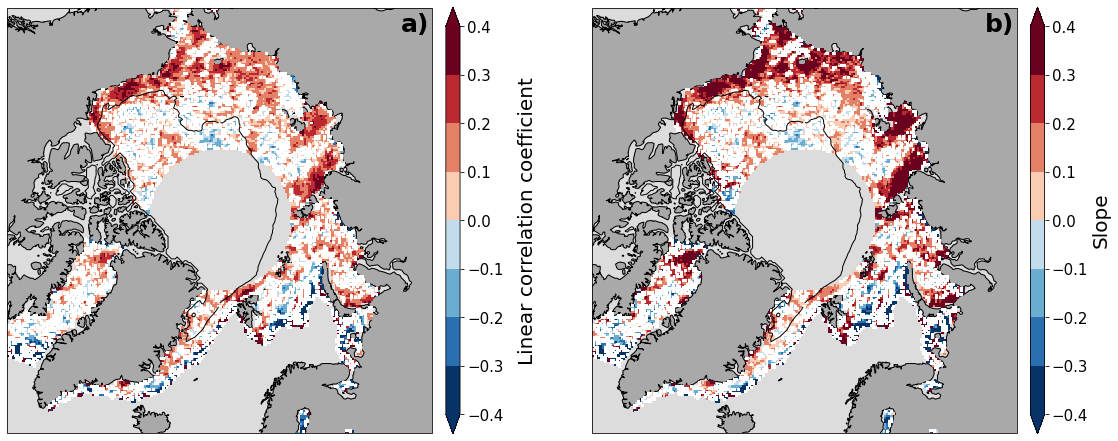

In [6]:
lats = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/lat_25km.npy')
lons = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/lon_25km.npy')

fig = plt.figure(figsize = (20,10))
spec = gridspec.GridSpec(ncols=2, nrows=1,wspace=0.1)

# correlations
rs_map[ps_map>0.05] = 1000
rs_map[rs_map==0] = 1000
grey = rs_map.copy()
grey[grey <1000] = np.nan
rs_map[rs_map==1000] = np.nan
list_colors = ['#073366','#2A70B1','#6BACD1','#C2DCEC','#FBCCB4','#E48066','#BA2832','#6A011F'] 

ax1 = fig.add_subplot(spec[0],projection=ccrs.NorthPolarStereo())
ax1.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=0)
ax1.add_feature(cartopy.feature.OCEAN, color='gainsboro', edgecolor='black')
ax1.coastlines()
ax1.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
cm = LinearSegmentedColormap.from_list('map', list_colors, N = 8)
p_map = ax1.pcolormesh(lons,lats,rs_map,cmap=cm, vmin=-0.4,vmax=0.4, transform=ccrs.PlateCarree())
ax1.pcolormesh(lons,lats,grey,cmap='Greys',vmin=1000,vmax=6000,transform=ccrs.PlateCarree())
ax1.set_title('a)', x = 0.96,y = 0.93,fontweight="bold", fontsize=25)
a = fig.colorbar(p_map,shrink=0.785,aspect=30,anchor=(-0.2,0.5),extend='both')
a.set_label("Linear correlation coefficient",fontsize=20,labelpad=15)
a.ax.tick_params(labelsize=15)

lon2d_greater = ma.masked_greater(np.array(icetype_lon), -0.01)
lon2d_lesser = ma.masked_less(np.array(icetype_lon), 0)

lat2d_greater = ma.MaskedArray(np.array(icetype_lat), mask=lon2d_greater.mask)
lat2d_lesser = ma.MaskedArray(np.array(icetype_lat), mask=lon2d_lesser.mask)

ice_type_lesser = ma.MaskedArray(day_ave, mask=lon2d_lesser.mask)
ice_type_greater = ma.MaskedArray(day_ave, mask=lon2d_greater.mask)

cont_less = ax1.contour(lon2d_lesser,
                  lat2d_lesser,
                  ice_type_lesser,
                  levels=[0.5],
                  transform=ccrs.PlateCarree(),
                  colors='k',
                  linewidths=1)

cont_Great = ax1.contour(lon2d_greater,
                  lat2d_greater,
                  ice_type_greater,
                  levels=[0.5],
                  transform=ccrs.PlateCarree(),
                  colors='k',
                  linewidths=1)

# slopes
ax2 = fig.add_subplot(spec[1],projection=ccrs.NorthPolarStereo())
ax2.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=0)
ax2.add_feature(cartopy.feature.OCEAN, color='gainsboro', edgecolor='black')
ax2.coastlines()
ax2.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
cm = LinearSegmentedColormap.from_list('map', list_colors, N = 8)
p_map = ax2.pcolormesh(lons,lats,ss_map,cmap=cm, vmin=-0.4,vmax=0.4, transform=ccrs.PlateCarree())
ax2.pcolormesh(lons,lats,grey,cmap='Greys',vmin=1000,vmax=6000,transform=ccrs.PlateCarree())
ax2.set_title('b)', x = 0.96,y = 0.93,fontweight="bold", fontsize=25)
a = fig.colorbar(p_map,shrink=0.785,aspect=30,anchor=(-0.2,0.5),extend='both')
a.set_label("Slope",fontsize=20)
a.ax.tick_params(labelsize=15)

lon2d_greater = ma.masked_greater(np.array(icetype_lon), -0.01)
lon2d_lesser = ma.masked_less(np.array(icetype_lon), 0)

lat2d_greater = ma.MaskedArray(np.array(icetype_lat), mask=lon2d_greater.mask)
lat2d_lesser = ma.MaskedArray(np.array(icetype_lat), mask=lon2d_lesser.mask)

ice_type_lesser = ma.MaskedArray(day_ave, mask=lon2d_lesser.mask)
ice_type_greater = ma.MaskedArray(day_ave, mask=lon2d_greater.mask)

cont_less = ax2.contour(lon2d_lesser,
                  lat2d_lesser,
                  ice_type_lesser,
                  levels=[0.5],
                  transform=ccrs.PlateCarree(),
                  colors='k',
                  linewidths=1)

cont_Great = ax2.contour(lon2d_greater,
                  lat2d_greater,
                  ice_type_greater,
                  levels=[0.5],
                  transform=ccrs.PlateCarree(),
                  colors='k',
                  linewidths=1)

plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/Snow Interpolated Freeboards/supp_figs/altika.png',bbox_inches = "tight", dpi = 400)